Sistema de inferencia de Takagi-Sugeno
===

* 30 min | Última modificación: Junio 1, 2021 | [YouTube]

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Modelo de Takagi-Sugeno

En los sistemas de Mamdani, las reglas tienen conjutnos difusos en sus consecuentes. Por ejemplo:

**IF** $x$ **IS** $A_i$ **AND** $y$ **IS**  $B_j$ **AND** $u$ **IS** $C_k$, **THEN** $z$  **IS** $D_n$

En los sistemas de Takagi-Sugeno (TS), el consecuente es una función. Por ejemplo:

**IF** $x$ **IS** $A_i$ **AND** $y$ **IS**  $B_j$ **AND** $u$ **IS** $C_k$, **THEN** $z=w_0 + w_1 x + w_2 y + w_3 u$ 


El valor de la composición de los antecedentes de cada regla ($w_r$) se puede calcular usando min o product, al igual que en los sistemas Mamdani. Si $z_r$ representa la salida obtenida al evaluar la regla $r$, la salida del sistema puede calcularse como:

$$
Z = \frac{\sum_r w_r r_r}{\sum_r w_r}
$$

## Especificación de los conjuntos borrosos

Usualmente se especifican como conjuntos borrosos triangulares con parámetros $(a, b, c)$.

In [2]:
import matplotlib.pyplot as plt
import numpy as np


class FuzzyVariable:
    def __init__(self, name, universe, nsets=2):
        #
        # Una variable difusa tiene definidos un nombre y
        # un universo X.
        #
        self.name = name
        self.universe = universe
        self.nsets = nsets
        self.sets = []

        #
        # Genera los conjuntos difusos igualmente espaciados
        #
        delta_x = float(universe[1] - universe[0]) / (nsets - 1)

        a = universe[0] - delta_x
        b = universe[0]
        c = universe[0] + delta_x

        for i_set in range(nsets):
            self.sets.append(np.array([a, b, c]))
            a += delta_x
            b += delta_x
            c += delta_x

    def compute_membership(self, x, fuzzyset):
        #
        # Los conjuntos borrosos son especificados usando
        # funciones de pertenencia triangulares
        #
        a = self.sets[fuzzyset][0]
        b = self.sets[fuzzyset][1]
        c = self.sets[fuzzyset][2]

        if x <= a:
            return 0.0
        if x <= b:
            return (x - a) / (b - a)
        if x <= c:
            return (x - c) / (b - c)

        return 0.0

    def plot(self, figsize=(10, 3)):
        #
        # Grafíca la función de pertenencia de cada conjunto
        # difuso definido para la variable
        #
        plt.figure(figsize=figsize)
        x = np.linspace(
            start=self.universe[0],
            stop=self.universe[1],
            num=200,
        )
        for i, _ in enumerate(self.sets):
            membership = [self.compute_membership(xi, i) for xi in x]
            plt.plot(x, membership, "-")
        plt.title(self.name)
        plt.ylim(-0.05, 1.05)

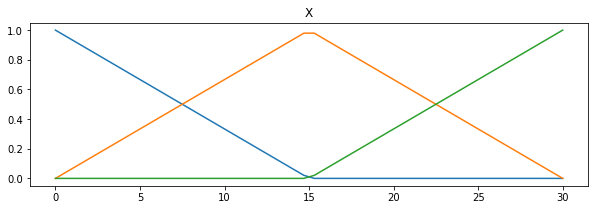

In [3]:
#
# Como ejemplo se define una variable difusa x
#
x_var = FuzzyVariable(
    #
    # Nombre de la variable
    #
    name="X",
    #
    # El universo está definido por sus valores máximo y
    # minimo.
    #
    universe=(0, 30),
    #
    # Los conjuntos borrosos se reparte uniformemente sobre
    # el universo.
    #
    nsets=3,
)

#
# Conjuntos borrosos. Note que los conjuntos están
# espaciados a lo largo del eje. El final de un conjunto
# coincide con el pico de otro conjunto.
#
x_var.plot()

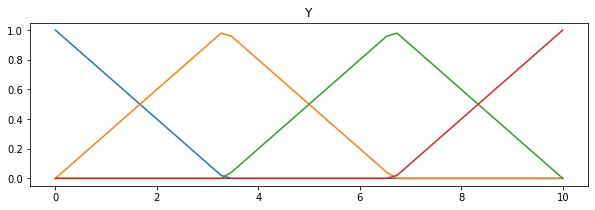

In [4]:
#
# Se define otra variable difusa y
#
y_var = FuzzyVariable(
    name="Y",
    universe=(0, 10),
    nsets=4,
)

#
# Conjuntos borrosos
#
y_var.plot()

## Especificación del modelo de Takagi-Sugeno

In [36]:
class TakagiSugeno:
    def __init__(self, inputs, seed=None):
        #
        # Este tipo de modelos recibe las variables de
        # entrada con sus conjuntos borrosos definidos
        # como se indico
        #
        self.inputs = inputs

        #
        # La construcción de las reglas se hace
        # automaticamente en un esquema de todos contra
        # todos.
        #
        self.antecedents = None
        self.intercept = None
        self.coefs = None

        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)

    def build_antecedents(self):
        #
        # Esta componente construye los antecedentes de las
        # reglas. Si la variable x tiene 2 conjuntos y la
        # variable y tiene 3 conjuntos, genera las reglas
        # posibles asi (6 reglas en total):
        #
        #    x   y
        # ----------
        # [
        #   [0, 0],
        #   [0, 1],
        #   [0, 2],
        #   [1, 0],
        #   [1, 1],
        #   [1, 2],
        # ]
        #
        def connect(sets):
            #
            # Esta es una función auxiliar recursiva
            #
            if len(sets) == 1:
                return [[i] for i in range(sets[0])]
            else:
                cur = sets[0]
                tail = sets[1:]
                return [[i] + e for e in connect(tail) for i in range(cur)]

        #
        # Llama a la función recursiva
        #
        sets = [var.nsets for var in self.inputs[:]]
        self.antecedents = connect(sets)

    def build_consequents(self):
        #
        # Genera la matriz de coeficientes de las reglas y
        # el vector de valores de los interceptos
        #
        nvars = len(self.inputs)
        nrules = len(self.antecedents)
        self.coefs = self.rng.uniform(low=-1, high=1, size=(nrules, nvars))
        self.intercept = self.rng.uniform(low=-1, high=1, size=nrules)

    def build_model(self):
        #
        # Función para construir el modelo a partir de la
        # información de configuración
        #
        self.build_antecedents()
        self.build_consequents()

    def __call__(self, X):
        #
        # Computa la salida del modelo para una matriz de
        # entradas X
        #
        self.compute_memberships(X)
        self.compute_composition()
        self.compute_consequents(X)
        self.compute_weighted_averages()
        return self.result

    def compute_memberships(self, X):
        #
        # Esta función construye una matriz similar a la
        # matriz de conjuntos de los antecedentes, pero con
        # los valores de la función de pertenencia para la
        # matriz X. El resultado es una lista de matrices
        #
        memberships = []
        for xi in X:
            memberships.append(
                [
                    [
                        self.inputs[i].compute_membership(x, a)
                        for i, (x, a) in enumerate(zip(xi, rule))
                    ]
                    for rule in self.antecedents
                ]
            )
        self.memberships = memberships

    def compute_composition(self):
        #
        # Calcula la composición de cada regla usando la
        # función min para cada regla.
        #
        self.composition = [
            [np.min(rule) for rule in point] for point in self.memberships
        ]

    def compute_consequents(self, X):
        #
        # Computa la salida de las reglas para cada fila
        # de X
        #
        self.consequents = [np.matmul(self.coefs, xi) + self.intercept for xi in X]

    def compute_weighted_averages(self):
        #
        # Computa la salida ponderada entre el peso de la
        # regla y el valor de la composición
        #
        self.result = np.array(
            [
                np.sum(composition * consequents) / np.sum(composition)
                for composition, consequents in zip(self.composition, self.consequents)
            ]
        )

    def fit(self, X, y, learning_rate=0.01, max_iter=100):

        
        self.model2vector()
        
        for iter in range(max_iter):

            grad_sets = self.compute_grad_sets(X, y)
            grad_coefs = self.compute_grad_coefs(X, y)
            grad_intercepts = self.compute_grad_intercept(X, y)

            self.model2vector()
            self.vector_sets -= learning_rate * np.array(grad_sets)
            self.vector_coefs -= learning_rate * np.array(grad_coefs)
            self.vector_intercept -= learning_rate * np.array(grad_intercepts)
            
            print("Iter={}, MSE={}".format(iter, self.compute_mse(X, y)))

    def model2vector(self):
        self.vector_sets = np.array(
            [p for var in self.inputs for s in var.sets for p in s]
        )
        self.vector_coefs = self.coefs.flatten()
        self.vector_intercept = self.intercept.flatten()

    def vector2model(self):
        #
        # fuzzy sets de las variables de entrada
        #
        counter = 0
        for var in self.inputs:
            for s in var.sets:
                s[0] = self.vector_sets[counter]
                counter += 1
                s[1] = self.vector_sets[counter]
                counter += 1
                s[2] = self.vector_sets[counter]
                counter += 1

        #
        # coeficientes de las reglas
        #
        self.coefs = np.array(self.vector_coefs).reshape(self.coefs.shape)

        #
        # interceptos de las reglas
        #
        self.intercept = np.array(self.vector_intercept).reshape(self.intercept.shape)

    def compute_mse(self, X, y):
        y_pred = self.__call__(X)
        return np.mean((np.array(y) - y_pred) ** 2)

    def compute_grad_sets(self, X, y):

        base = self.compute_mse(X, y)
        original_vector = self.vector_sets[:]
        grad = []
        for i in range(len(self.vector_sets)):
            self.vector_sets = original_vector.copy()
            self.vector_sets[i] += 0.001
            self.vector2model()
            mse = self.compute_mse(X, y)
            grad.append((mse - base) / 0.001)

        self.vector_sets = original_vector.copy()
        self.vector2model()
        return grad

    def compute_grad_coefs(self, X, y):

        base = self.compute_mse(X, y)
        original_vector = self.vector_coefs[:]
        grad = []
        for i in range(len(self.vector_coefs)):
            self.vector_coefs = original_vector.copy()
            self.vector_coefs[i] += 0.001
            self.vector2model()
            mse = self.compute_mse(X, y)
            grad.append((mse - base) / 0.001)

        self.vector_coefs = original_vector.copy()
        self.vector2model()
        return grad

    def compute_grad_intercept(self, X, y):

        base = self.compute_mse(X, y)
        original_vector = self.vector_intercept[:]
        grad = []
        for i in range(len(self.vector_intercept)):
            self.vector_intercept = original_vector.copy()
            self.vector_intercept[i] += 0.001
            self.vector2model()
            mse = self.compute_mse(X, y)
            grad.append((mse - base) / 0.001)

        self.vector_intercept = original_vector.copy()
        self.vector2model()
        return grad

In [37]:
#
# Ejemplo de la salida de un modelo de Takagi-Sugeno
#
model = TakagiSugeno(inputs=[x_var, y_var])

#
# Se construye la estructura interna del modelo con valores
# aleatorios para los coeficientes y el intercepto de las
# reglas
#
model.build_model()

#
# Se computa la salida del sistema para tres patrones de
# entrada
#
model(
    [
        [1.0, 2.0],
        [0.5, 3.0],
        [2.0, 4.0],
    ]
)

array([-0.49454234,  0.60670542,  0.51937762])

## Ejemplo numérico

In [46]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/concrete.csv",
    sep=",",
    thousands=None,
    decimal=".",
)

scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

X_train = df_norm.copy()
X_train = X_train[["cement", "slag", "ash"]]
y_train = df_norm.strength

cement = FuzzyVariable(name="cement", universe=(0, 1), nsets=3)
slag = FuzzyVariable(name="slag", universe=(0, 1), nsets=3)
ash = FuzzyVariable(name="ash", universe=(0, 1), nsets=3)

model = TakagiSugeno(inputs=[cement, slag, ash])
model.build_model()
model.fit(X_train.values, y_train.values, learning_rate=0.001, max_iter=10)

Iter=0, MSE=0.47029211574319707
Iter=1, MSE=0.4678208749704715
Iter=2, MSE=0.4680119736853287
Iter=3, MSE=0.4654405585158718
Iter=4, MSE=0.4653576220157457
Iter=5, MSE=0.46297865401328175
Iter=6, MSE=0.4626321695580012
Iter=7, MSE=0.46051997804568773
Iter=8, MSE=0.46011564429850493
Iter=9, MSE=0.4581646520864437


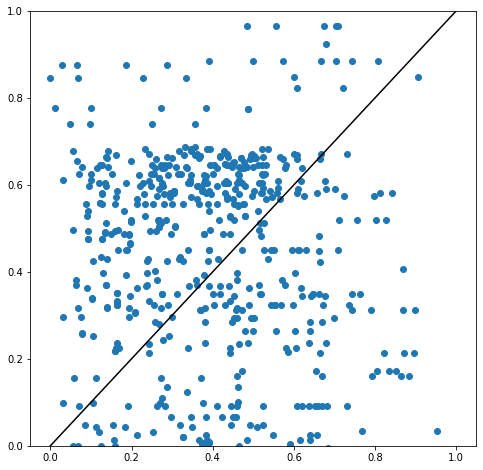

In [47]:
y_pred = model(X_train.values)
plt.figure(figsize=(8, 8))
plt.scatter(y_train.values, y_pred)
plt.plot([0, 1], [0, 1], color="black")
plt.ylim(0, 1);

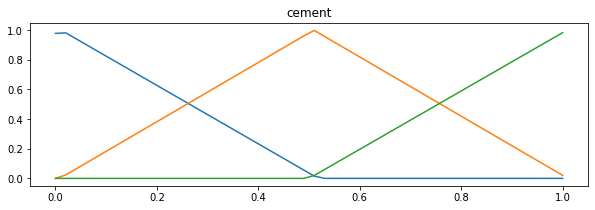

In [48]:
cement.plot()

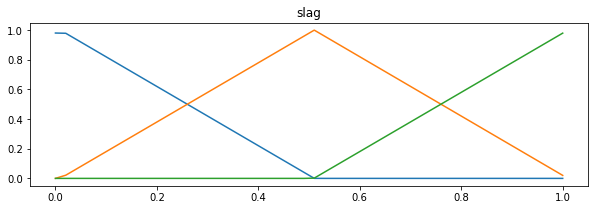

In [49]:
slag.plot()

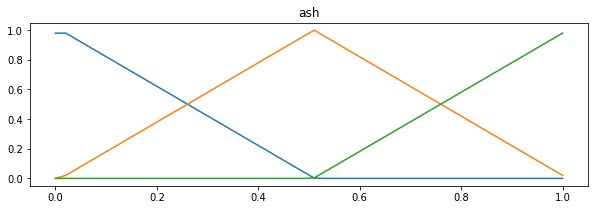

In [50]:
ash.plot()

In [51]:
model.coefs

array([[-0.15247285,  0.2800051 ,  0.72270919],
       [-0.79873311, -0.84910882,  0.96997348],
       [ 0.47609095, -0.57674779,  0.91061043],
       [-0.55604097,  0.4252909 , -0.62286883],
       [ 0.12328201, -0.72134509, -0.2546066 ],
       [ 0.79615475, -0.71371943,  0.80249115],
       [-0.83960366,  0.96880278, -0.8687667 ],
       [-0.45267322, -0.76749135, -0.7279484 ],
       [-0.60566046,  0.94694916, -0.09880541],
       [ 0.96498826,  0.46006217,  0.1215366 ],
       [ 0.32457253,  0.54618621,  0.50932401],
       [ 0.31759832, -0.73894596, -0.70679607],
       [ 0.83835525, -0.70377684, -0.95179226],
       [-0.57533823, -0.8622082 ,  0.58116879],
       [ 0.9474852 ,  0.86519152,  0.74357234],
       [ 0.86848209, -0.83764765,  0.83022871],
       [ 0.46139286, -0.7023921 , -0.87847752],
       [ 0.41119141, -0.58636479,  0.90067736],
       [-0.94892483,  0.87533258, -0.11624488],
       [-0.12800566, -0.93503928,  0.33028349],
       [-0.20938898,  0.2229827 ,  0.839

In [53]:
model.intercept

array([ 0.68470334, -0.69898138,  0.65387423,  0.70931693, -0.31980116,
        0.65976903,  0.99326221,  0.02457875,  0.15374249,  0.43398503,
        0.27187292, -0.86388201, -0.64788874, -0.39731638,  0.87093957,
        0.37190886,  0.70954806,  0.41833099,  0.2793416 ,  0.35314988,
        0.67338546,  0.35611338,  0.96521628, -0.60047178, -0.45906585,
       -0.07112289,  0.7349576 ])